## Setup

In [2]:
# Import statements
import xarray as xr
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
from metpy.plots import ctables
import numpy as np
from xskillscore import resample_iterations_idx
from dask.diagnostics.progress import ProgressBar
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.feature as cfeature
from typing import List
import matplotlib.patches as patches

plt.style.use("dark_background")
mpl.rcParams["hatch.linewidth"] = 0.2

In [3]:
# Define functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    return smoothed_da

def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )

def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)

def process_and_smooth(data: xr.DataArray|xr.Dataset, times: List[str], smooth_data: bool=True):
    processed_data = xr.concat([data.sel(time=t).squeeze() for t in times], dim="time").mean(dim="run").compute() #type: ignore
    if smooth_data:
        return smooth(processed_data)
    return processed_data

# Function to perform resampling and compute means
def resample_and_compute_means(data, time, lat_chunk=50, lon_chunk=50, iterations=1000, dim_max=20):
    chunked_data = data.sel(time=time).squeeze().chunk({"lat": lat_chunk, "lon": lon_chunk})
    set1 = resample_iterations_idx(chunked_data, iterations, dim="run", replace=False, dim_max=dim_max).mean(dim="run")
    set2 = resample_iterations_idx(chunked_data, iterations, dim="run", replace=False, dim_max=dim_max).mean(dim="run")
    return set1, set2

# Function to compute differences and quantiles
def compute_difference_and_quantiles(set1, set2):
    return (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()

def calc_theta(T: xr.DataArray, p: int) -> xr.DataArray:
    """Calculate potential temperature in Kelvin."""
    return (T + 273.15) * ((1000 / p) ** 0.286)

# Compute masks
def compute_mask(diff, results):
    return (diff < results.sel(quantile=0.05).squeeze()) | (
        diff > results.sel(quantile=0.95).squeeze()
    )

In [4]:
# Read in WoFS initializations 20–23Z
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [5]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Get MetPy colortables
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## Create wet & dry ensembles

In [6]:
# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Sort by Central Park precipitation
rain_nyc_0102 = [
    w.rain.isel(lat=lat_ind, lon=lon_ind)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .squeeze()
    for w in wofs_all
]

# Get indices of wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]

# Select wet and dry members
wofs_wet = [w.sel(ne=ne_wet[i].astype(int)) for i, w in enumerate(wofs_all)]
wofs_dry = [w.sel(ne=ne_dry[i].astype(int)) for i, w in enumerate(wofs_all)]

## Calculate Frontogenesis

In [21]:
# Grab the variables
uv850_all = xr.merge(
    [process_variable(wofs_all, "U_850"), process_variable(wofs_all, "V_850")]
)
uv850_wet = xr.merge(
    [
        process_variable(wofs_wet, "U_850", overwrite=True),
        process_variable(wofs_wet, "V_850", overwrite=True),
    ]
)
uv850_dry = xr.merge(
    [
        process_variable(wofs_dry, "U_850", overwrite=True),
        process_variable(wofs_dry, "V_850", overwrite=True),
    ]
)

# Process temperature data for all, wet, and dry conditions at 850mb
theta850_all = calc_theta(process_variable(wofs_all, "temperature_850"), 850)
theta850_wet = calc_theta(
    process_variable(wofs_wet, "temperature_850", overwrite=True), 850
)
theta850_dry = calc_theta(
    process_variable(wofs_dry, "temperature_850", overwrite=True), 850
)

for d in [uv850_all,uv850_wet, uv850_dry, theta850_all, theta850_wet, theta850_dry]:
    d["lat"] = d.lat*3000
    d["lon"] = d.lon*3000

In [1]:
xr.DataArray.cf

NameError: name 'xr' is not defined

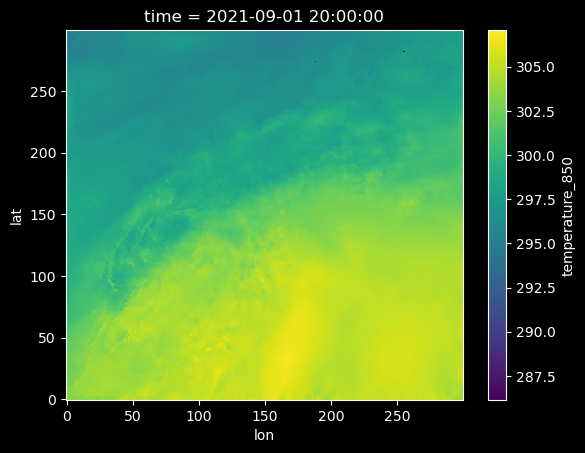

In [11]:
theta850_all.isel(time=0).mean(dim="run").plot()

In [24]:
theta850_all.shape

(109, 300, 300, 72)